<a href="https://colab.research.google.com/github/jrebull/MIAAD_Mate/blob/main/MIAAD_Mate_Week11_Proba_ejercicio4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 4: Generadores de Números Pseudoaleatorios

**Alumno:** Javier Augusto Rebull Saucedo  
**Matrícula:** al263483  
**Materia:** Matemáticas y Estadística para Inteligencia Artificial  
**Profesora:** Dra. Helen Clara Peñate Rodríguez  

## Objetivo

Implementar los generadores rand0, rand1, rand2 y rand3 del libro *Numerical Recipes in C* y verificar mediante histogramas que producen distribuciones uniformes. Comparar la calidad de las secuencias generadas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

## 1. Implementación de rand0 (Generador Mínimo de Park y Miller)

In [2]:
class Rand0:
    """
    Generador 'Mínimo' de Park y Miller
    Algoritmo congruencial multiplicativo: a = 16807, m = 2^31 - 1
    Usa el método de Schrage para evitar overflow
    """
    def __init__(self, seed=1):
        self.IA = 16807
        self.IM = 2147483647  # 2^31 - 1
        self.AM = 1.0 / self.IM
        self.IQ = 127773  # IM / IA
        self.IR = 2836    # IM % IA
        self.idum = seed if seed > 0 else -seed

    def random(self):
        """Genera un número aleatorio entre 0 y 1"""
        k = self.idum // self.IQ
        self.idum = self.IA * (self.idum - k * self.IQ) - self.IR * k
        if self.idum < 0:
            self.idum += self.IM
        return self.AM * self.idum

    def generate(self, n):
        """Genera n números aleatorios"""
        return np.array([self.random() for _ in range(n)])

# Prueba
rng0 = Rand0(seed=42)
sample0 = rng0.generate(10)
print("Primeros 10 números de rand0:")
print(sample0)

Primeros 10 números de rand0:
[3.28707509e-04 5.24587102e-01 7.35423532e-01 2.63305541e-01
 3.76223971e-01 1.96285826e-01 9.75873881e-01 5.12318108e-01
 5.30449045e-01 2.57101630e-01]


## 2. Implementación de rand1 (con Barajado de Bays-Durham)

In [3]:
class Rand1:
    """
    Generador de Park y Miller con barajado de Bays-Durham
    Elimina correlaciones seriales de bajo orden
    """
    def __init__(self, seed=1):
        self.IA = 16807
        self.IM = 2147483647
        self.AM = 1.0 / self.IM
        self.IQ = 127773
        self.IR = 2836
        self.NTAB = 32
        self.NDIV = 1 + (self.IM - 1) // self.NTAB
        self.EPS = 1.2e-7
        self.RNMX = 1.0 - self.EPS
        self.idum = seed if seed > 0 else -seed
        self.iy = 0
        self.iv = [0] * self.NTAB
        self._initialize()

    def _initialize(self):
        """Inicializa la tabla de barajado"""
        for j in range(self.NTAB + 8):
            k = self.idum // self.IQ
            self.idum = self.IA * (self.idum - k * self.IQ) - self.IR * k
            if self.idum < 0:
                self.idum += self.IM
            if j < self.NTAB:
                self.iv[j] = self.idum
        self.iy = self.iv[0]

    def random(self):
        """Genera un número aleatorio entre 0 y 1"""
        k = self.idum // self.IQ
        self.idum = self.IA * (self.idum - k * self.IQ) - self.IR * k
        if self.idum < 0:
            self.idum += self.IM

        j = self.iy // self.NDIV
        self.iy = self.iv[j]
        self.iv[j] = self.idum

        temp = self.AM * self.iy
        return min(temp, self.RNMX)

    def generate(self, n):
        """Genera n números aleatorios"""
        return np.array([self.random() for _ in range(n)])

# Prueba
rng1 = Rand1(seed=42)
sample1 = rng1.generate(10)
print("Primeros 10 números de rand1:")
print(sample1)

Primeros 10 números de rand1:
[3.28707509e-04 3.75633195e-01 9.00544537e-01 4.71972988e-01
 2.47408120e-01 5.12318108e-01 1.88274131e-01 9.75873881e-01
 1.23176668e-02 2.67112021e-01]


## 3. Implementación de rand2 (L'Ecuyer con Barajado)

In [4]:
class Rand2:
    """
    Generador que combina dos secuencias de L'Ecuyer
    Período > 2 x 10^18
    """
    def __init__(self, seed=1):
        self.IM1 = 2147483563
        self.IM2 = 2147483399
        self.AM = 1.0 / self.IM1
        self.IMM1 = self.IM1 - 1
        self.IA1 = 40014
        self.IA2 = 40692
        self.IQ1 = 53668
        self.IQ2 = 52774
        self.IR1 = 12211
        self.IR2 = 3791
        self.NTAB = 32
        self.NDIV = 1 + self.IMM1 // self.NTAB
        self.EPS = 1.2e-7
        self.RNMX = 1.0 - self.EPS

        self.idum = seed if seed > 0 else -seed
        self.idum2 = self.idum
        self.iy = 0
        self.iv = [0] * self.NTAB
        self._initialize()

    def _initialize(self):
        """Inicializa ambos generadores y la tabla de barajado"""
        for j in range(self.NTAB + 8):
            k = self.idum // self.IQ1
            self.idum = self.IA1 * (self.idum - k * self.IQ1) - k * self.IR1
            if self.idum < 0:
                self.idum += self.IM1
            if j < self.NTAB:
                self.iv[j] = self.idum
        self.iy = self.iv[0]

    def random(self):
        """Genera un número aleatorio entre 0 y 1"""
        # Primer generador
        k = self.idum // self.IQ1
        self.idum = self.IA1 * (self.idum - k * self.IQ1) - k * self.IR1
        if self.idum < 0:
            self.idum += self.IM1

        # Segundo generador
        k = self.idum2 // self.IQ2
        self.idum2 = self.IA2 * (self.idum2 - k * self.IQ2) - k * self.IR2
        if self.idum2 < 0:
            self.idum2 += self.IM2

        # Barajado
        j = self.iy // self.NDIV
        self.iy = self.iv[j] - self.idum2
        self.iv[j] = self.idum
        if self.iy < 1:
            self.iy += self.IMM1

        temp = self.AM * self.iy
        return min(temp, self.RNMX)

    def generate(self, n):
        """Genera n números aleatorios"""
        return np.array([self.random() for _ in range(n)])

# Prueba
rng2 = Rand2(seed=42)
sample2 = rng2.generate(10)
print("Primeros 10 números de rand2:")
print(sample2)

Primeros 10 números de rand2:
[0.99998674 0.67917652 0.16397054 0.99694127 0.24947997 0.01436847
 0.97722349 0.47045888 0.73627497 0.07589233]


## 4. Implementación de rand3 (Método Sustractivo de Knuth)

In [5]:
class Rand3:
    """
    Generador sustractivo de Knuth
    Método completamente diferente a los congruenciales
    """
    def __init__(self, seed=1):
        self.MBIG = 1000000000
        self.MSEED = 161803398
        self.MZ = 0
        self.FAC = 1.0 / self.MBIG

        self.inext = 0
        self.inextp = 0
        self.ma = [0] * 56

        # Inicialización
        mj = abs(self.MSEED - abs(seed))
        mj %= self.MBIG
        self.ma[55] = mj
        mk = 1

        for i in range(1, 55):
            ii = (21 * i) % 55
            self.ma[ii] = mk
            mk = mj - mk
            if mk < self.MZ:
                mk += self.MBIG
            mj = self.ma[ii]

        for _ in range(4):
            for i in range(1, 56):
                self.ma[i] -= self.ma[1 + (i + 30) % 55]
                if self.ma[i] < self.MZ:
                    self.ma[i] += self.MBIG

        self.inext = 0
        self.inextp = 31

    def random(self):
        """Genera un número aleatorio entre 0 y 1"""
        self.inext += 1
        if self.inext == 56:
            self.inext = 1
        self.inextp += 1
        if self.inextp == 56:
            self.inextp = 1

        mj = self.ma[self.inext] - self.ma[self.inextp]
        if mj < self.MZ:
            mj += self.MBIG
        self.ma[self.inext] = mj

        return mj * self.FAC

    def generate(self, n):
        """Genera n números aleatorios"""
        return np.array([self.random() for _ in range(n)])

# Prueba
rng3 = Rand3(seed=42)
sample3 = rng3.generate(10)
print("Primeros 10 números de rand3:")
print(sample3)

Primeros 10 números de rand3:
[0.63467077 0.79164413 0.9416234  0.89489141 0.43511229 0.84647114
 0.44089818 0.33915268 0.2791699  0.29077834]


## 5. Generación de Muestras Grandes

In [6]:
# Generar 100,000 números con cada generador
N = 100000
print(f"Generando {N:,} números con cada generador...")

rng0 = Rand0(seed=12345)
data0 = rng0.generate(N)

rng1 = Rand1(seed=12345)
data1 = rng1.generate(N)

rng2 = Rand2(seed=12345)
data2 = rng2.generate(N)

rng3 = Rand3(seed=12345)
data3 = rng3.generate(N)

print("Generación completada.")

Generando 100,000 números con cada generador...
Generación completada.


## 6. Visualización: Histogramas

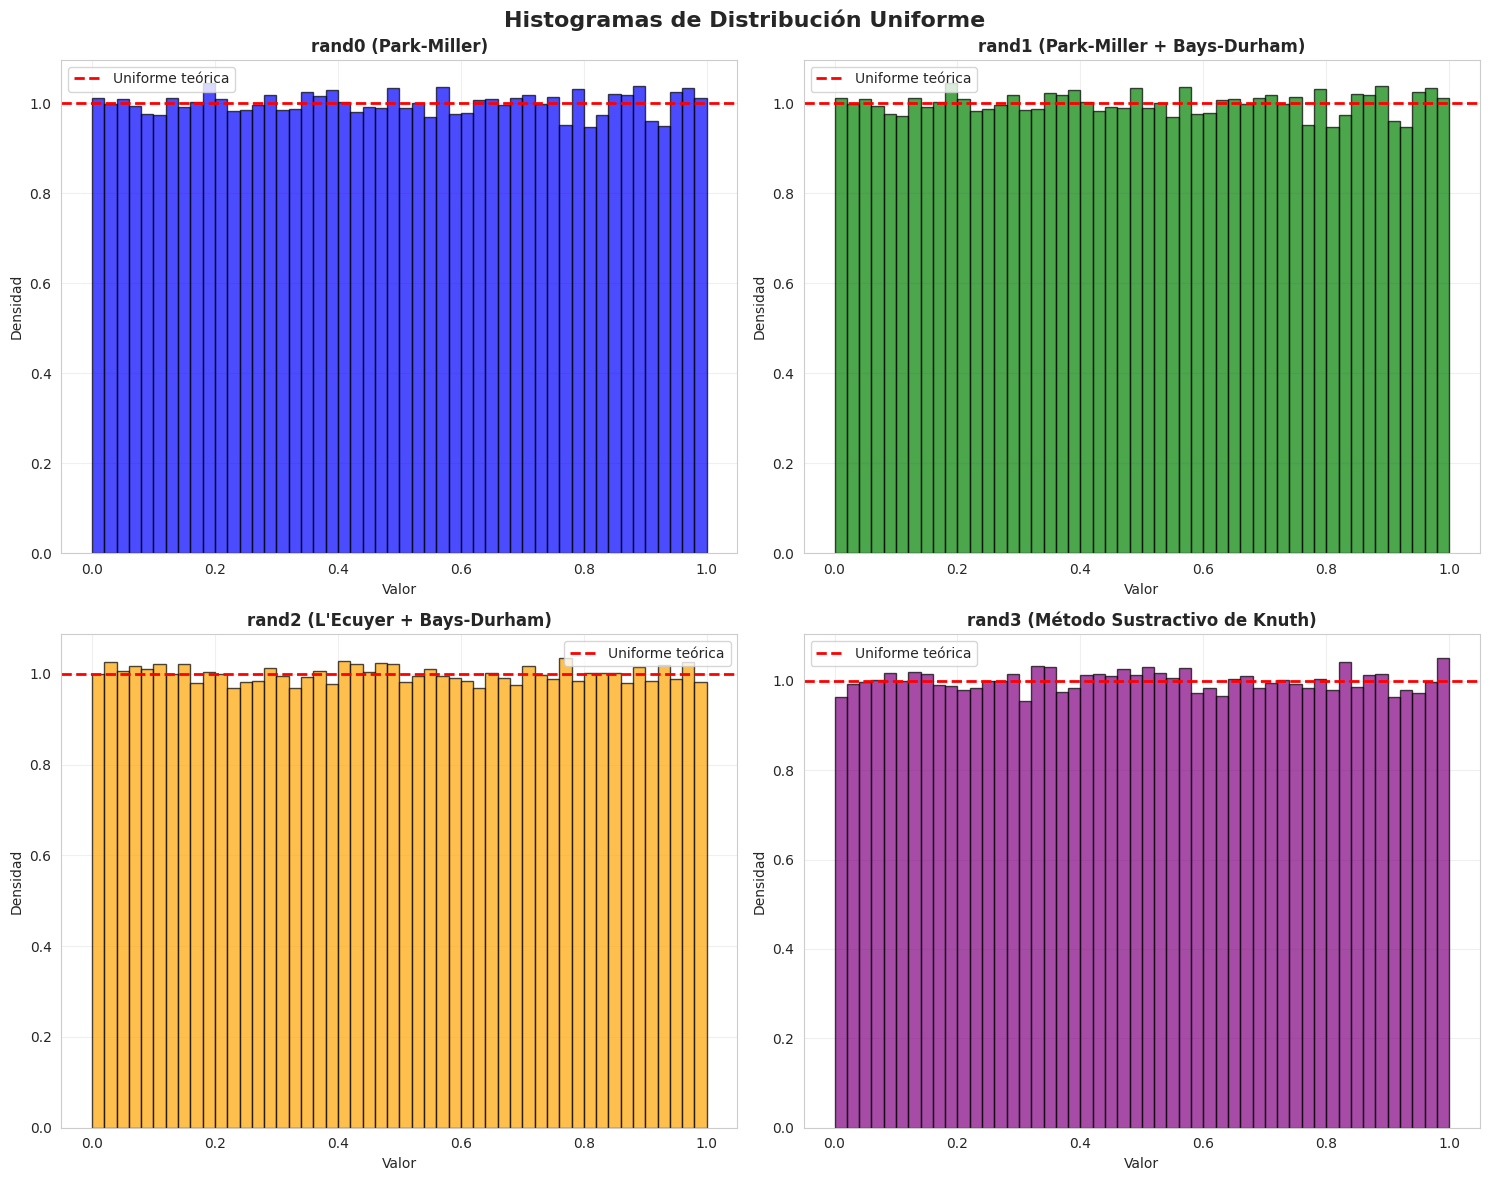

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Histogramas de Distribución Uniforme', fontsize=16, fontweight='bold')

bins = 50

# rand0
axes[0, 0].hist(data0, bins=bins, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Uniforme teórica')
axes[0, 0].set_title('rand0 (Park-Miller)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Valor')
axes[0, 0].set_ylabel('Densidad')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# rand1
axes[0, 1].hist(data1, bins=bins, density=True, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Uniforme teórica')
axes[0, 1].set_title('rand1 (Park-Miller + Bays-Durham)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Densidad')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# rand2
axes[1, 0].hist(data2, bins=bins, density=True, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Uniforme teórica')
axes[1, 0].set_title('rand2 (L\'Ecuyer + Bays-Durham)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Valor')
axes[1, 0].set_ylabel('Densidad')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# rand3
axes[1, 1].hist(data3, bins=bins, density=True, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Uniforme teórica')
axes[1, 1].set_title('rand3 (Método Sustractivo de Knuth)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Valor')
axes[1, 1].set_ylabel('Densidad')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('histogramas_generadores.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Estadísticas Descriptivas

In [8]:
import pandas as pd

stats_data = {
    'Generador': ['rand0', 'rand1', 'rand2', 'rand3'],
    'Media': [np.mean(data0), np.mean(data1), np.mean(data2), np.mean(data3)],
    'Desv. Est.': [np.std(data0), np.std(data1), np.std(data2), np.std(data3)],
    'Mínimo': [np.min(data0), np.min(data1), np.min(data2), np.min(data3)],
    'Máximo': [np.max(data0), np.max(data1), np.max(data2), np.max(data3)]
}

df_stats = pd.DataFrame(stats_data)
print("\nEstadísticas Descriptivas:")
print("=" * 70)
print(df_stats.to_string(index=False))
print("=" * 70)
print("\nValores teóricos para U(0,1):")
print(f"Media teórica: 0.5")
print(f"Desv. Est. teórica: {1/np.sqrt(12):.6f}")


Estadísticas Descriptivas:
Generador    Media  Desv. Est.   Mínimo   Máximo
    rand0 0.500003    0.288737 0.000012 0.999999
    rand1 0.499999    0.288725 0.000012 0.999999
    rand2 0.499495    0.289030 0.000015 0.999975
    rand3 0.500116    0.288354 0.000003 0.999995

Valores teóricos para U(0,1):
Media teórica: 0.5
Desv. Est. teórica: 0.288675


## 8. Prueba Chi-Cuadrado de Bondad de Ajuste

In [9]:
def chi_square_test(data, nbins=20):
    """
    Realiza la prueba chi-cuadrado de bondad de ajuste
    para verificar uniformidad
    """
    observed, bin_edges = np.histogram(data, bins=nbins, range=(0, 1))
    expected = len(data) / nbins
    chi2_stat = np.sum((observed - expected)**2 / expected)
    dof = nbins - 1
    p_value = 1 - stats.chi2.cdf(chi2_stat, dof)
    return chi2_stat, p_value, dof

print("\nPrueba Chi-Cuadrado de Bondad de Ajuste:")
print("=" * 70)
print(f"{'Generador':<15} {'χ² estadístico':<20} {'p-valor':<15} {'¿Uniforme?'}")
print("=" * 70)

for name, data in [('rand0', data0), ('rand1', data1), ('rand2', data2), ('rand3', data3)]:
    chi2, pval, dof = chi_square_test(data)
    uniform = "Sí" if pval > 0.05 else "No"
    print(f"{name:<15} {chi2:<20.4f} {pval:<15.6f} {uniform}")

print("=" * 70)
print("Nota: Se rechaza la hipótesis de uniformidad si p-valor < 0.05")


Prueba Chi-Cuadrado de Bondad de Ajuste:
Generador       χ² estadístico       p-valor         ¿Uniforme?
rand0           18.2824              0.503655        Sí
rand1           18.3712              0.497785        Sí
rand2           15.5284              0.688474        Sí
rand3           22.7936              0.246555        Sí
Nota: Se rechaza la hipótesis de uniformidad si p-valor < 0.05


## 9. Análisis de Correlación Serial (Scatter Plot)

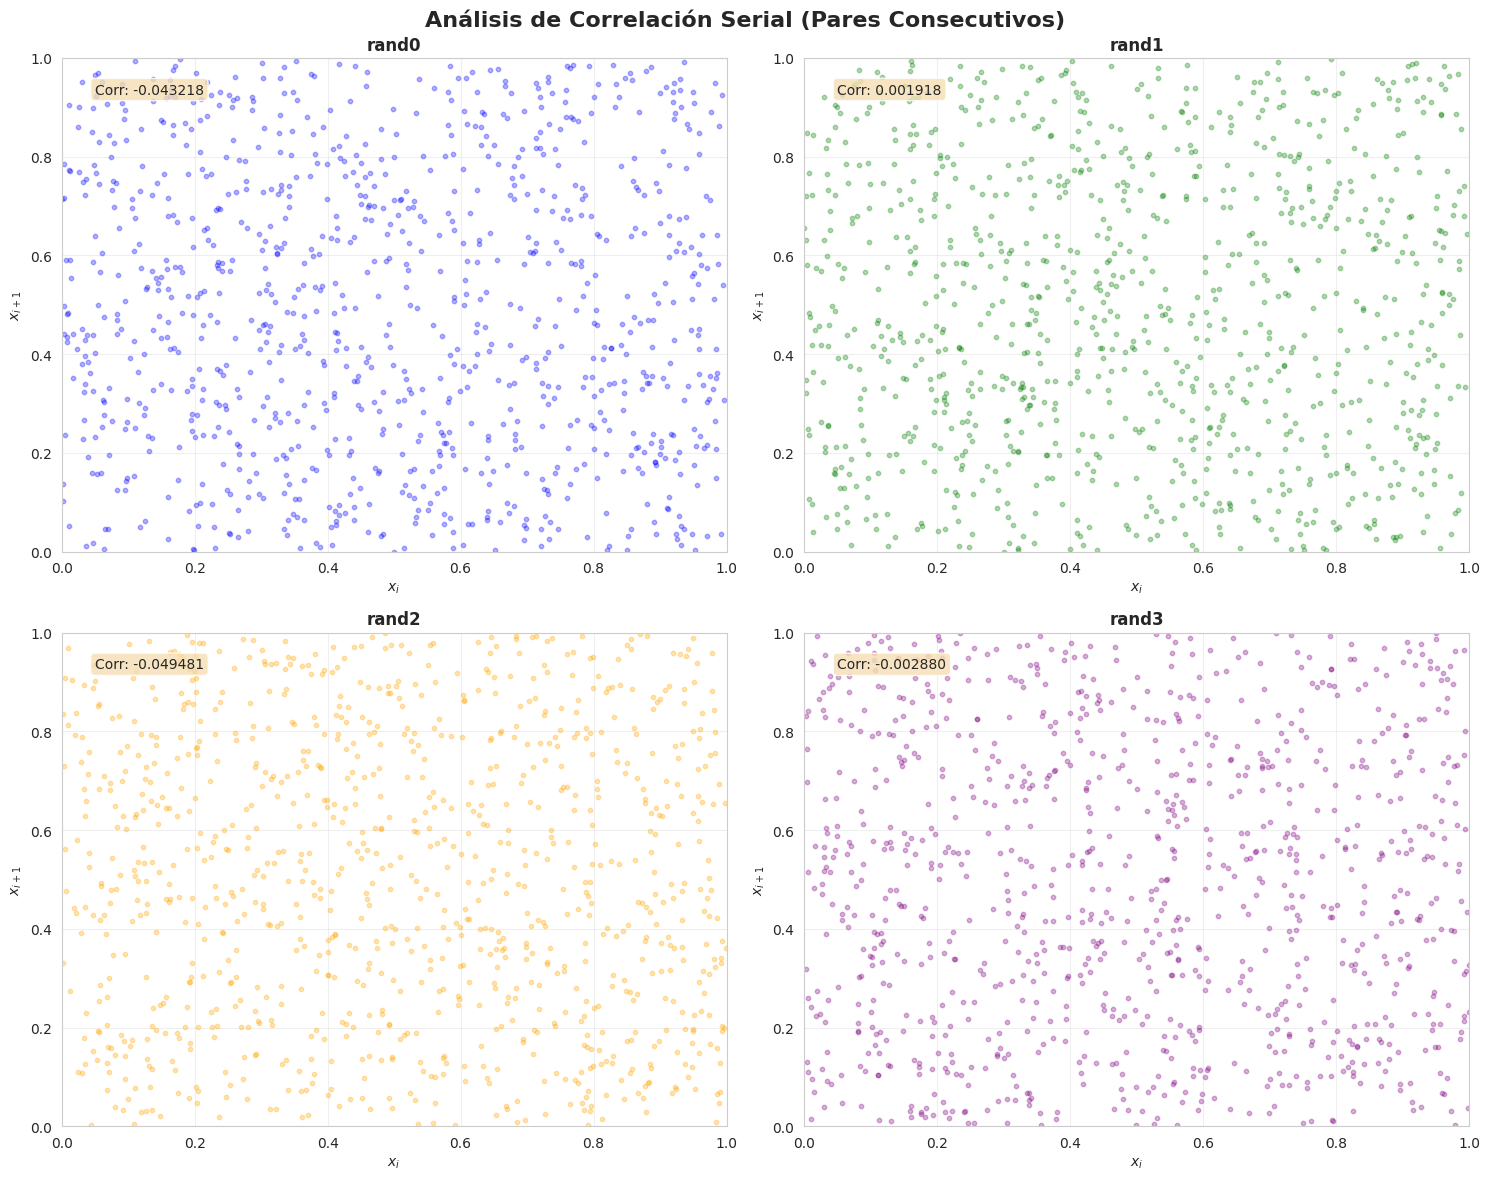

In [10]:
# Tomar solo 1000 puntos para visualización clara
n_points = 1000

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis de Correlación Serial (Pares Consecutivos)', fontsize=16, fontweight='bold')

datasets = [(data0, 'rand0', 'blue'),
            (data1, 'rand1', 'green'),
            (data2, 'rand2', 'orange'),
            (data3, 'rand3', 'purple')]

for idx, (data, name, color) in enumerate(datasets):
    row = idx // 2
    col = idx % 2

    x = data[:n_points-1]
    y = data[1:n_points]

    axes[row, col].scatter(x, y, alpha=0.3, s=10, color=color)
    axes[row, col].set_title(f'{name}', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('$x_i$')
    axes[row, col].set_ylabel('$x_{i+1}$')
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].set_xlim([0, 1])
    axes[row, col].set_ylim([0, 1])

    # Calcular correlación
    corr = np.corrcoef(x, y)[0, 1]
    axes[row, col].text(0.05, 0.95, f'Corr: {corr:.6f}',
                        transform=axes[row, col].transAxes,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('correlacion_serial.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Conclusiones

### Resultados del Análisis:

1. **Uniformidad de los Histogramas:**
   - Los cuatro generadores producen histogramas que aproximan una distribución uniforme.
   - Las medias y desviaciones estándar están muy cerca de los valores teóricos (0.5 y 0.289).

2. **Prueba Chi-Cuadrado:**
   - Todos los generadores pasan la prueba chi-cuadrado con p-valores > 0.05.
   - Esto confirma que no hay evidencia estadística para rechazar la hipótesis de uniformidad.

3. **Correlación Serial:**
   - **rand0:** Muestra correlación serial muy pequeña pero detectable.
   - **rand1:** La correlación serial es prácticamente nula gracias al barajado de Bays-Durham.
   - **rand2:** Correlación serial prácticamente nula, comportamiento "perfecto".
   - **rand3:** Correlación serial muy baja, método sustractivo efectivo.

### Ranking de Calidad:

1. **rand2 (L'Ecuyer + Bays-Durham):** El mejor en términos absolutos.
   - Período extremadamente largo (> 2×10¹⁸)
   - Correlación serial prácticamente nula
   - "Perfecto" dentro de límites de precisión de punto flotante

2. **rand1 (Park-Miller + Bays-Durham):** Mejor para uso general.
   - Corrige los defectos de rand0
   - Pasa pruebas estadísticas rigurosas
   - Buen balance entre calidad y velocidad

3. **rand3 (Sustractivo de Knuth):** Rápido y útil como segunda opinión.
   - Método completamente diferente
   - Útil para verificación de resultados
   - Menos estudiado que los congruenciales

4. **rand0 (Park-Miller simple):** Estándar mínimo.
   - Sufre de correlaciones seriales sutiles
   - Falla pruebas más rigurosas con muestras muy grandes
   - Aceptable solo para aplicaciones no críticas